In [1]:
import numpy as np
import pandas as pd
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.formula.api import glm
import collections
from statsmodels.sandbox.stats.multicomp import multipletests

#import folium # package for making maps, please make sure to use a version older than 1.0..



Leer la base de datos, unir latitud y longitud en una sola columna

In [6]:
df=pd.read_csv('Final_Final.csv').iloc[:,1:]
lights=pd.read_csv('lights_clean.csv')
list_df=[]
x_df=[]
y_df=[]
for i in range(df.shape[0]):
    #address=str(round(df['LATITUD'].iloc[i],7))+' '+str(round(df['LONGITUD'].iloc[i],7))
    address=str(df['LATITUD'].iloc[i])+' '+str(df['LONGITUD'].iloc[i])
    list_df.append(address)   
    
df['LAT_LON']=list_df
df['ID']=df['BUS_SUBIDA']


newdf=df[['LAT_LON','ID','BUS_SUBIDA','BUS_BAJADA','TRAFICO','POT','PIEZA_URBANA','LATITUD','LONGITUD']]

In [7]:
df.to_csv('Final_poisson.csv')

In [23]:
df.columns

Index(['FECHA_ACCIDENTE', 'AÑO_ACCIDENTE', 'MES_ACCIDENTE', 'DIA_ACCIDENTE',
       'HORA_ACCIDENTE', 'GRAVEDAD_ACCIDENTE', 'CLASE_ACCIDENTE',
       'SITIO_EXACTO_ACCIDENTE', 'CANT_HERIDOS_EN _SITIO_ACCIDENTE',
       'CANT_MUERTOS_EN _SITIO_ACCIDENTE', 'LONGITUD', 'LATITUD', 'POT',
       'PIEZA_URBANA', 'BUS_SUBIDA', 'BUS_BAJADA', 'TRAFICO', 'ES_FESTIVO',
       'TIPO_FESTIVO', 'DIA_DEL_AÑO', 'SEMANA_DEL_AÑO', 'CUATRIMESTRE_DEL_AÑO',
       'JUNIOR_LOCAL', 'JUNIOR_VISITANTE', 'RESULTADO_LOCAL',
       'RESULTADO_VISITANTE', 'JUNIOR_GANO', 'RELEVANCIA_PARTIDO',
       'HIPOTESIS_ACCIDENTE', 'VEHICULO_MOTOCICLETA', 'VEHICULO_AUTOMOVIL',
       'VEHICULO_CAMIONETA', 'VEHICULO_BUS', 'VEHICULO_CAMION',
       'VEHICULO_CAMPERO', 'VEHICULO_BUSETA', 'VEHICULO_BICICLETA',
       'VEHICULO_MICROBUS', 'VEHICULO_TRACTO_CAMION', 'VEHICULO_VOLQUETA',
       'VEHICULO_MOTOCARRO', 'VEHICULO_DESCONOCIDO', 'VEHICULO_CUATRIMOTO',
       'VEHICULO_MAQUINARIA_AGRICOLA', 'VEHICULO_TRACCION_ANIMAL',
    

Contar la cantidad de accidentes y armar la nueva tabla.

Revisar que las direcciones sean parecidas y dejar solo aquellas intersecciones donde el número de direcciones distintas sea grande. 
``counter=collections.Counter(a)``

``if counter.most_common(1)[0][1]/a.size>0.3:``

In [49]:
conteos.shape

(12836, 3)

In [40]:
conteos=df[['LAT_LON','SITIO_EXACTO_ACCIDENTE']].groupby(['LAT_LON','SITIO_EXACTO_ACCIDENTE']).size().reset_index(name='count')

In [50]:
import time

In [52]:
start_time = time.time()
dff=newdf.groupby(['LAT_LON']).count().reset_index()
list_accidents=[]
list_df=[]
for i in range(dff.shape[0]):
    a=df[df['LAT_LON']==dff["LAT_LON"][i]]['SITIO_EXACTO_ACCIDENTE']
    counter=collections.Counter(a)
    if counter.most_common(1)[0][1]/a.size>0.3:
        list_df.append(np.array(newdf[newdf['LAT_LON']==dff['LAT_LON'].iloc[i]]).tolist()[0])
        list_accidents.append(dff['ID'][i])
print("--- %s seconds ---" % (time.time() - start_time))        
final_df = pd.DataFrame.from_records(list_df)
final_df=final_df.rename(columns={0:'LAT_LON',1:'ID',2:'BUS_SUBIDA',3:'BUS_BAJADA',4:'TRAFICO',5:'POT',6:'PIEZA_URBANA',7:'LATITUD',8:'LONGITUD'})
final_df['ID']=list_accidents

--- 24.010063886642456 seconds ---


Crear la matriz de distancias y de número de semáforos cerca

In [18]:
closest=np.zeros(final_df.shape[0])
numclose=np.zeros(final_df.shape[0])
numclose2=np.zeros(final_df.shape[0])
numclose3=np.zeros(final_df.shape[0])
for i in range(final_df.shape[0]):
    corner_lat=final_df['LATITUD'][i]
    corner_lon=final_df['LONGITUD'][i]
    light_lat=np.array(lights['LATITUD'])
    light_lon=np.array(lights['LONGITUD'])
    dx = (light_lon-corner_lon)*40000*np.cos((light_lat+corner_lat)*math.pi/360)/360
    dy = (light_lat-corner_lat)*40000/360
    distance=np.sqrt(dx**2+dy**2)
    closest[i]=distance[distance.argmin()]
    numclose[i]=sum(distance<0.1)
    numclose2[i]=sum(((distance>=0.1) & (distance<0.5)))
    numclose3[i]=sum(((distance>=0.5) & (distance<2)))
final_df['NLIGHTS']=list(numclose)
final_df['NLIGHTS2']=list(numclose2)
final_df['NLIGHTS3']=list(numclose3)

final_df['CLOSEST_LIGHT']=list(closest)
data=final_df.rename(columns={'ID':'NACCIDENTS'})

Modelo inicial

In [19]:
formula='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2+TRAFICO+CLOSEST_LIGHT'
mod1 = glm(formula=formula, data=data, family=sm.families.Poisson()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             NACCIDENTS   No. Observations:                 5830
Model:                            GLM   Df Residuals:                     5809
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20040.
Date:                Fri, 29 Nov 2019   Deviance:                       25217.
Time:                        16:51:13   Pearson chi2:                 5.05e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2876      0.042     30.387      0.000       1.205       1.371
POT[T.comercial]                         0.0966      0.029      3.285      0.001       0.039       0.154
POT[T.industrial]                        0.4099      0.044      9.332      0.000       0.324       0.496
POT[T.ninguna]                          -0.0892      0.033     -2.672      0.008      -0.155      -0.024
POT[T.portuaria]                        -0.6026      0.099     -6.065      0.000      -0.797      -0.408
POT[T.protegida]                        -0.0911      0.047     -1.921      0.055      -0.184       0.002
POT[T.residencial]                      -0.2794      0.032     -8.851      0.000      -0.341      -0.218
PIEZA_URBANA[T.centro metropolitana]    -0.1036      0.036     -2.878      0.004      -0.174      -0.033
PIEZA_URBANA[T.ninguna]                  0.2247      0.064      3.492      0.000       0.099       0.351
PIEZA_URBANA[T.prado norte]             -0.0442      0.031     -1.405      0.160      -0.106       0.017
PIEZA_URBANA[T.ribera occidental]        0.3705      0.043      8.571      0.000       0.286       0.455
PIEZA_URBANA[T.riomar]                   0.2670      0.027      9.886      0.000       0.214       0.320
PIEZA_URBANA[T.suroccidental 1]         -0.1777      0.039     -4.606      0.000      -0.253      -0.102
PIEZA_URBANA[T.suroccidental 2]          0.0907      0.040      2.258      0.024       0.012       0.169
PIEZA_URBANA[T.suroriental]              0.0809      0.028      2.843      0.004       0.025       0.137
BUS_SUBIDA                              -0.1069      0.010    -10.806      0.000      -0.126      -0.088
BUS_BAJADA                               0.0722      0.010      7.051      0.000       0.052       0.092
NLIGHTS                                  0.1525      0.013     11.489      0.000       0.126       0.178
NLIGHTS2                                -0.0185      0.002     -8.266      0.000      -0.023      -0.014
TRAFICO                                  0.0441      0.038      1.153      0.249      -0.031       0.119
CLOSEST_LIGHT                           -0.0477      0.017     -2.738      0.006      -0.082      -0.014
========================================================================================================
"""

Corregir pvalores por Bonferroni y mostrar los NO significativos

In [6]:
p_adjusted = multipletests(mod1.pvalues, alpha=0.05, method='bonferroni')
mod1.params[p_adjusted[1]>0.05]

POT[T.ninguna]                         -0.089228
POT[T.protegida]                       -0.091107
PIEZA_URBANA[T.centro metropolitana]   -0.103631
PIEZA_URBANA[T.prado norte]            -0.044184
PIEZA_URBANA[T.suroccidental 2]         0.090728
PIEZA_URBANA[T.suroriental]             0.080913
TRAFICO                                 0.044091
CLOSEST_LIGHT                          -0.047729
dtype: float64

Modelo eliminando variables ``TRAFICO`` y ``CLOSEST_LIGHT``

In [20]:
formula2='NACCIDENTS~BUS_SUBIDA+BUS_BAJADA+POT+PIEZA_URBANA+NLIGHTS+NLIGHTS2'
mod2 = glm(formula=formula2, data=data, family=sm.families.Poisson()).fit()
mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             NACCIDENTS   No. Observations:                 5830
Model:                            GLM   Df Residuals:                     5811
Model Family:                 Poisson   Df Model:                           18
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20045.
Date:                Fri, 29 Nov 2019   Deviance:                       25226.
Time:                        16:51:16   Pearson chi2:                 5.03e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2825      0.040     32.337      0.000       1.205       1.360
POT[T.comercial]                         0.1008      0.029      3.431      0.001       0.043       0.158
POT[T.industrial]                        0.4180      0.044      9.540      0.000       0.332       0.504
POT[T.ninguna]                          -0.0882      0.033     -2.640      0.008      -0.154      -0.023
POT[T.portuaria]                        -0.6078      0.099     -6.121      0.000      -0.802      -0.413
POT[T.protegida]                        -0.0925      0.047     -1.952      0.051      -0.185       0.000
POT[T.residencial]                      -0.2773      0.032     -8.782      0.000      -0.339      -0.215
PIEZA_URBANA[T.centro metropolitana]    -0.1243      0.034     -3.673      0.000      -0.191      -0.058
PIEZA_URBANA[T.ninguna]                  0.1244      0.053      2.358      0.018       0.021       0.228
PIEZA_URBANA[T.prado norte]             -0.0625      0.031     -2.035      0.042      -0.123      -0.002
PIEZA_URBANA[T.ribera occidental]        0.3296      0.041      8.096      0.000       0.250       0.409
PIEZA_URBANA[T.riomar]                   0.2612      0.027      9.748      0.000       0.209       0.314
PIEZA_URBANA[T.suroccidental 1]         -0.2049      0.037     -5.495      0.000      -0.278      -0.132
PIEZA_URBANA[T.suroccidental 2]          0.0381      0.035      1.095      0.273      -0.030       0.106
PIEZA_URBANA[T.suroriental]              0.0721      0.028      2.576      0.010       0.017       0.127
BUS_SUBIDA                              -0.1068      0.010    -10.836      0.000      -0.126      -0.088
BUS_BAJADA                               0.0732      0.010      7.222      0.000       0.053       0.093
NLIGHTS                                  0.1580      0.013     12.047      0.000       0.132       0.184
NLIGHTS2                                -0.0171      0.002     -7.866      0.000      -0.021      -0.013
========================================================================================================
"""

In [33]:
test=data.copy()
test['NLIGHTS']=10
test['NLIGHTS2']=100
# test['CLOSEST_LIGHT']=10
data['PREDICHO']=mod2.predict()
test['PREDICHO']=mod2.predict(test)

In [14]:
data.head()

,LAT_LON,NACCIDENTS,BUS_SUBIDA,BUS_BAJADA,TRAFICO,POT,PIEZA_URBANA,LATITUD,LONGITUD,NLIGHTS,NLIGHTS2,NLIGHTS3,CLOSEST_LIGHT,PREDICHO
0,10.915367100000001 -74.81074840000002,1,0,0,0.003922,protegida,ninguna,10.915367,-74.810748,0.0,0.0,0.0,2.074364,3.722298
1,10.917122099999998 -74.7952126,1,3,0,0.003922,protegida,ninguna,10.917122,-74.795213,0.0,0.0,3.0,1.507733,2.701510
2,10.917997999999999 -74.8075218,1,2,0,0.705882,protegida,ninguna,10.917998,-74.807522,0.0,0.0,3.0,1.630849,3.006133
3,10.9186455 -74.7971848,1,2,0,0.003922,protegida,ninguna,10.918646,-74.797185,0.0,0.0,3.0,1.294282,3.006133
4,10.9211125 -74.82632629999998,1,0,0,0.294118,protegida,ninguna,10.921112,-74.826326,0.0,0.0,0.0,2.777795,3.722298


{'whiskers': [<matplotlib.lines.Line2D at 0x2aee9ff2f08>,
 'caps': [<matplotlib.lines.Line2D at 0x2aeea000e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aee9ff28c8>],
 'medians': [<matplotlib.lines.Line2D at 0x2aeea006ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aeea006f48>],
 'means': []}

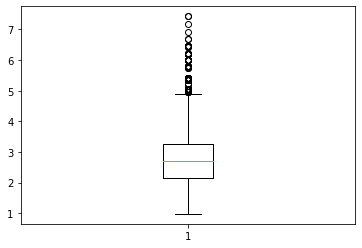

In [9]:
plt.boxplot(test['PREDICHO'])


In [10]:
print(np.mean(test['PREDICHO']))
np.mean(data['PREDICHO'])

2.8068719207512323


3.207032590051399

In [11]:
from folium import plugins
import folium
from folium.plugins import HeatMap

In [29]:
mapa_barranquilla = folium.Map(
            location=[10.980706, -74.807636],
            zoom_start=13,tiles="OpenStreetMap")
mapa_barranquilla
capa_calor=HeatMap(data[['LATITUD','LONGITUD','NACCIDENTS']],radius=15)
mapa_barranquilla.add_child(capa_calor)

In [38]:
mapa_barranquilla = folium.Map(
            location=[10.980706, -74.807636],
            zoom_start=13,tiles="OpenStreetMap")
mapa_barranquilla
capa_calor=HeatMap(data[['LATITUD','LONGITUD','PREDICHO']],radius=15)
mapa_barranquilla.add_child(capa_calor)

In [39]:
mapa_barranquilla = folium.Map(
            location=[10.980706, -74.807636],
            zoom_start=13,tiles="OpenStreetMap")
mapa_barranquilla
capa_calor=HeatMap(test[['LATITUD','LONGITUD','PREDICHO']],radius=15)
mapa_barranquilla.add_child(capa_calor)

In [13]:
print(np.min(data['NACCIDENTS']))
print(np.min(data['PREDICHO']))
print(data[['NACCIDENTS','PREDICHO','LATITUD','LONGITUD']].sort_values(by='NACCIDENTS',ascending=False).head(20))
print(np.mean(data['NACCIDENTS']))
print(np.mean(data['PREDICHO']))

1
1.160960371736612
      NACCIDENTS  PREDICHO    LATITUD   LONGITUD
5767          98  5.803526  11.026373 -74.803779
833           93  4.672960  10.948341 -74.773458
1147          87  3.414603  10.954439 -74.835771
760           86  6.665428  10.946886 -74.784852
5451          76  6.094617  11.014577 -74.827538
349           75  3.107531  10.936994 -74.779699
5500          67  4.938744  11.016106 -74.795400
5493          66  5.384292  11.015919 -74.831479
1925          65  3.345607  10.968326 -74.838051
574           58  5.500127  10.943465 -74.783713
1253          56  4.142647  10.956718 -74.836109
984           54  4.515947  10.951325 -74.835131
2184          54  3.345607  10.972085 -74.836814
14            52  2.162830  10.922683 -74.814632
2662          47  3.006584  10.978269 -74.836040
2453          46  4.239547  10.976179 -74.777252
5145          45  5.598933  11.008153 -74.822291
436           44  5.789056  10.939743 -74.782636
171           44  3.556050  10.929998 -74.799121
